In [113]:
import os
import re
import warnings
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from bootcampviztools import pinta_distribucion_categoricas
from nltk.corpus import stopwords
import nltk

# Configuracion
warnings.filterwarnings('ignore')

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [114]:
df_sample = pd.read_json(
    r"C:\Users\Vicky\Documents\ML_Amazon_Reviews_Analysis\data_sample\raw\cropped.jsonl",
    lines=True  
)


In [115]:
df_sample.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5,Such a lovely scent but not overpowering.,This spray is really nice. It smells really go...,[],B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,2020-05-05 14:08:48.923,0,True
1,4,Works great but smells a little weird.,"This product does what I need it to do, I just...",[],B081TJ8YS3,B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,2020-05-04 18:10:55.070,1,True
2,5,Yes!,"Smells good, feels great!",[],B07PNNCSP9,B097R46CSY,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,2020-05-16 21:41:06.052,2,True
3,1,Synthetic feeling,Felt synthetic,[],B09JS339BZ,B09JS339BZ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,2022-01-28 18:13:50.220,0,True
4,5,A+,Love it,[],B08BZ63GMJ,B08BZ63GMJ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,2020-12-30 10:02:43.534,0,True


### Exploracion inicial

Echamos un vistazo

In [117]:
# Obtener número de filas y columnas
num_filas, num_columnas = df_sample.shape

# Mostrar la información de dimensiones
print(f"\nDimensiones del DataFrame:")
print(f"- Número de filas (reseñas): {num_filas}")
print(f"- Número de columnas (variables): {num_columnas}")

# Mostrar los nombres de las columnas si es necesario
print("\nNombres de columnas:")
for i, columna in enumerate(df_sample.columns, 1):
    print(f"{i}. {columna}")


Dimensiones del DataFrame:
- Número de filas (reseñas): 8313
- Número de columnas (variables): 10

Nombres de columnas:
1. rating
2. title
3. text
4. images
5. asin
6. parent_asin
7. user_id
8. timestamp
9. helpful_vote
10. verified_purchase


In [118]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8313 entries, 0 to 8312
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   rating             8313 non-null   int64         
 1   title              8313 non-null   object        
 2   text               8313 non-null   object        
 3   images             8313 non-null   object        
 4   asin               8313 non-null   object        
 5   parent_asin        8313 non-null   object        
 6   user_id            8313 non-null   object        
 7   timestamp          8313 non-null   datetime64[ns]
 8   helpful_vote       8313 non-null   int64         
 9   verified_purchase  8313 non-null   bool          
dtypes: bool(1), datetime64[ns](1), int64(2), object(6)
memory usage: 592.8+ KB


#### Descripcion de las columnas
| **Columna**          | **Tipo de Dato** | **Relevancia para Análisis**                     | **Tratamiento Posible**                                                                 |
|----------------------|------------------|------------------------------------------------|-------------------------------------------------------------------------------------------|
| `rating`             | `float64`        | **Alta** (variable objetivo)                   | Convertir a escala discreta (1-2 = negativo, 3 = neutral, 4-5 = positivo).             |
| `title`              | `object`         | **Media** (contexto adicional)                 | Concatenar con `text` para análisis NLP.                          |
| `text`               | `object`         | **Crítica** (fuente primaria)                  | Limpieza de texto (stopwords, emojis, URLs), tokenización, y vectorización (TF-IDF/BOW).  |
| `images`             | `object`         | **Baja**                                       | **Eliminar**                                   |
| `asin`               | `object`         | **Nula**                                       | **Eliminar**                               |
| `parent_asin`        | `object`         | **Nula**                                       | **Eliminar**                                                         |
| `user_id`            | `object`         | **Nula**                                       | **Eliminar**                                   |
| `timestamp`          | `int64`          | **Baja**                                       | Lo convierto a fecha solo por si surge posibilidad de analisis temporal                     |
| `helpful_vote`       | `int64`          | **Media** (peso de confianza)                 | Normalizar o crear flag (ej: `helpful_vote > 5` = reseña destacada).                      |
| `verified_purchase`  | `bool`           | **Alta** (confiabilidad)                      | Convertir a binario (1/0) y usarlo como feature en el modelo.                             |

## Limpieza de Datos

Elimino nulos, duplicados y verifico tipos de datos

In [122]:
# Crear una copia del DataFrame original
df_reviews_clean = df_sample.copy()

# Eliminar nulos en la copia
df_reviews_clean = df_reviews_clean.dropna()

# Eliminar columnas no hashables en la copia
df_reviews_clean = df_reviews_clean.drop(columns=['images'])

# Eliminar duplicados en la copia
df_reviews_clean = df_reviews_clean.drop_duplicates()

# Eliminar otras columnas innecesarias en la copia
columnas_a_eliminar = ['asin', 'parent_asin', 'user_id','timestamp']
df_reviews_clean = df_reviews_clean.drop(columns=columnas_a_eliminar)

# Mostrar resultados
print("DataFrame original - Dimensiones:", df_sample.shape)
print("DataFrame limpio - Dimensiones:", df_reviews_clean.shape)
print("\nPrimeras filas del DataFrame limpio:")
df_reviews_clean.head()

DataFrame original - Dimensiones: (8313, 10)
DataFrame limpio - Dimensiones: (8306, 5)

Primeras filas del DataFrame limpio:


,rating,title,text,helpful_vote,verified_purchase
0,5,Such a lovely scent but not overpowering.,This spray is really nice. It smells really go...,0,True
1,4,Works great but smells a little weird.,"This product does what I need it to do, I just...",1,True
2,5,Yes!,"Smells good, feels great!",2,True
3,1,Synthetic feeling,Felt synthetic,0,True
4,5,A+,Love it,0,True


In [123]:
#Longitud promedio de las resenias: creo una nueva columna lenght con la longitud del texto de las mismas.

df_reviews_clean['length'] = df_reviews_clean['text'].apply(len)


In [124]:
#calculo la longitud promedio 
average_length = df_reviews_clean['length'].mean()
print(f"Longitud promedio de las reseñas: {average_length:.2f} caracteres.")

Longitud promedio de las reseñas: 316.36 caracteres.


### Visualizaciones
#### Distribución de Ratings

Se analiza la frecuencia de cada calificación con gráficos de barras y verificamos si hay desbalance en las categorías

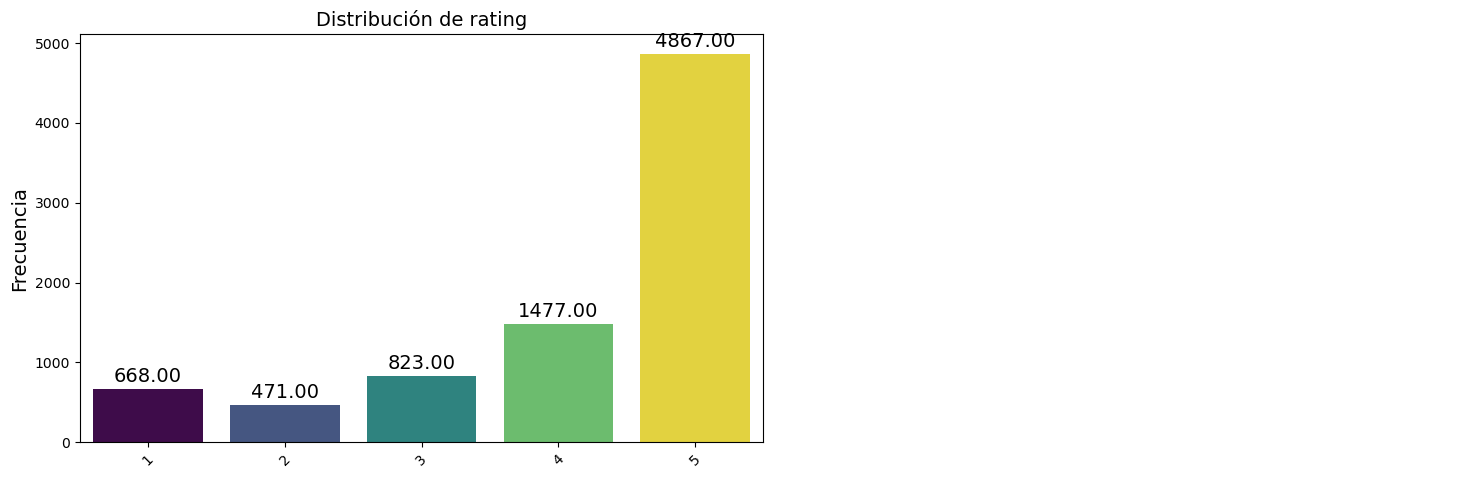

In [126]:
#Distribucion de las calificaciones (columna 'rating')
pinta_distribucion_categoricas(df_reviews_clean, columnas_categoricas=['rating'], mostrar_valores=True)

#### Frecuencia de compras verificadas

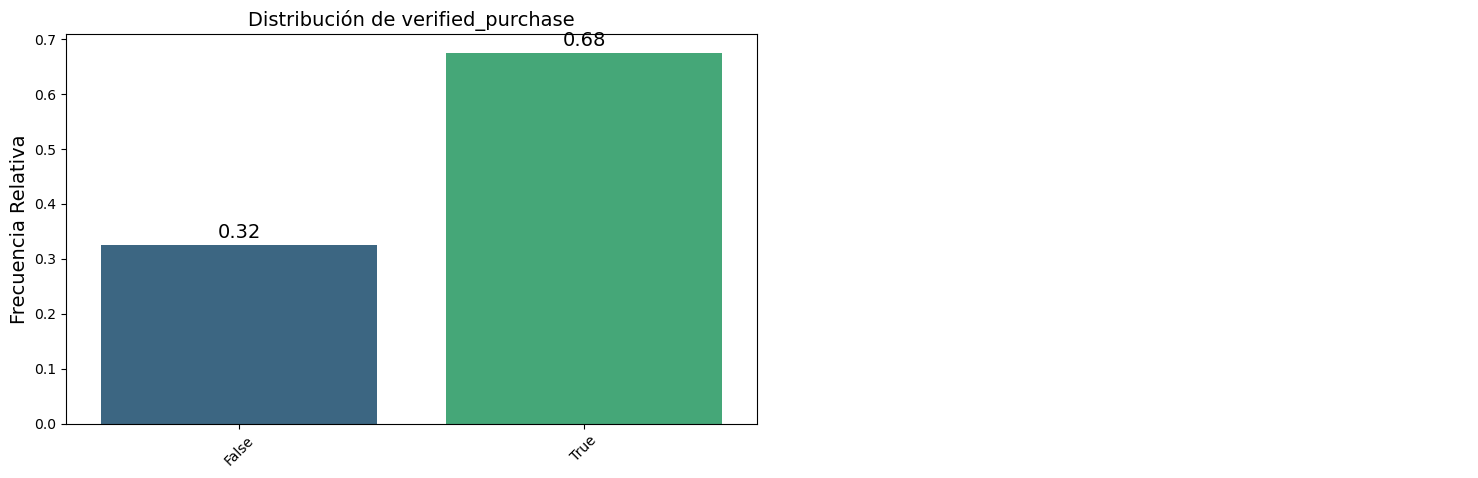

In [128]:
#Frecuencia de reseñas verificadas ('verified pur chase')
pinta_distribucion_categoricas(df_reviews_clean, columnas_categoricas=['verified_purchase'], relativa=True, mostrar_valores=True)


#### World Cloud 

Muestro las palabras más frecuentes en text_limpio separadas por sentimiento (positivo,neutral, negativo)


#### Boxplot o violinplot de longitud de texto

Comparo la distribución de la longitud de las reseñas según el sentimiento, respondiendo por ejemplo a si las reseñas negativas son más largas que las positivas.

#### Heatmap de correlaciones

Analizo correlación entre helpful_votes con rating o sentimiento

### Análisis Estadístico 

#### Test de Hipótesis
Aplico un test de chi-cuadrado para ver si ´verified_purchase´está asociado a ciertos ratings. Ej: Las compras verificadas tienden a tener ratings más altos? 

#### Análisis de sentimiento por tiempo

Con los datos temporales de 'timestamp' explorar tendencias, hay meses con mas reseñas negativas, cambia la distribuciòn de ratings con el tiempo? 

#### TF-IDF o N-gramas

Identifico frases claves bigramas o trigramas tìpicas de reseñas positivas/negativas. Por ej, ´no recomiendo´ en reseñas negativas o ´excelente producto´en positivas.

***Preguntas clave para profundizar:***


¿Existe diferencia en el vocabulario entre reseñas verificadas y no verificadas?

¿Los productos con más reseñas negativas tienen algo en común (ej: categoría, precio)?

¿Hay outliers en la longitud del texto que puedan indicar spam?

In [136]:
df_reviews_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8306 entries, 0 to 8312
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   rating             8306 non-null   int64 
 1   title              8306 non-null   object
 2   text               8306 non-null   object
 3   helpful_vote       8306 non-null   int64 
 4   verified_purchase  8306 non-null   bool  
 5   length             8306 non-null   int64 
dtypes: bool(1), int64(3), object(2)
memory usage: 397.5+ KB
